# Chapter 7: Ensemble Learning and Random Forests

## Pengantar

**Ensemble Learning** adalah salah satu teknik paling kuat dalam Machine Learning yang menggabungkan prediksi dari beberapa model (predictor) untuk menghasilkan prediksi yang lebih baik daripada model individual. Konsep ini didasarkan pada prinsip "wisdom of the crowd" - dimana agregasi jawaban dari banyak individu sering kali lebih akurat daripada jawaban dari satu ahli.

### Konsep Dasar Ensemble Learning

Ensemble Learning bekerja dengan cara:
1. Melatih beberapa model yang berbeda (disebut base learners atau weak learners)
2. Menggabungkan prediksi dari semua model tersebut
3. Menghasilkan prediksi final yang biasanya lebih akurat dan robust

## 1. Voting Classifiers

### Penjelasan Teoretis

**Voting Classifier** adalah metode ensemble yang paling sederhana. Ada dua jenis voting:

1. **Hard Voting**: Setiap classifier memberikan satu vote untuk kelas yang diprediksi, dan kelas dengan vote terbanyak menjadi prediksi final.
2. **Soft Voting**: Menggunakan probabilitas kelas dari setiap classifier dan mengambil rata-rata probability, kemudian memilih kelas dengan probability tertinggi.

### Mengapa Voting Classifier Bekerja?

Analoginya seperti melempar koin bias dengan probabilitas 51% untuk heads. Jika kita melempar 1000 kali, kemungkinan mendapatkan mayoritas heads adalah sekitar 75%. Semakin banyak lemparan, semakin tinggi probabilitasnya karena **Law of Large Numbers**.

In [12]:
# Import library yang diperlukan
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Buat dataset untuk demonstrasi
X, y = make_moons(n_samples=1000, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Implementasi Hard Voting Classifier

In [13]:
# Buat individual classifiers
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

# Buat Voting Classifier dengan hard voting
voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)

# Latih voting classifier
voting_clf.fit(X_train, y_train)

# Evaluasi setiap classifier
print("Akurasi Individual Classifiers dan Voting Classifier:")
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"{clf.__class__.__name__}: {accuracy_score(y_test, y_pred):.3f}")

Akurasi Individual Classifiers dan Voting Classifier:
LogisticRegression: 0.820
RandomForestClassifier: 0.905
SVC: 0.915
VotingClassifier: 0.905


### Implementasi Soft Voting Classifier

In [14]:
# Untuk soft voting, kita perlu mengatur probability=True untuk SVM
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)  # Aktifkan probability estimation

# Buat Voting Classifier dengan soft voting
soft_voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft'
)

soft_voting_clf.fit(X_train, y_train)
y_pred = soft_voting_clf.predict(X_test)
print(f"Soft Voting Classifier: {accuracy_score(y_test, y_pred):.3f}")

Soft Voting Classifier: 0.920


**Mengapa Soft Voting Lebih Baik?**
Soft voting memberikan bobot lebih pada prediksi yang lebih confident. Jika satu classifier sangat yakin (probability 0.99) dan yang lain ragu-ragu (probability 0.51), soft voting akan memberikan pengaruh lebih besar pada classifier yang confident.

## 2. Bagging dan Pasting

### Penjelasan Teoretis

**Bagging** (Bootstrap Aggregating) dan **Pasting** adalah teknik ensemble yang menggunakan algoritma yang sama untuk setiap predictor, tetapi melatihnya pada subset data yang berbeda:

- **Bagging**: Sampling dengan replacement (bootstrap sampling)
- **Pasting**: Sampling tanpa replacement

### Keuntungan Bagging dan Pasting

1. **Bias-Variance Tradeoff**: Mengurangi variance tanpa meningkatkan bias secara signifikan
2. **Parallelization**: Setiap predictor dapat dilatih secara parallel
3. **Robustness**: Mengurangi overfitting

In [15]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

# Implementasi Bagging
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=True,  # True untuk bagging, False untuk pasting
    n_jobs=-1,
    random_state=42
)

bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)
print(f"Bagging Classifier Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# Implementasi Pasting
paste_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    max_samples=100, 
    bootstrap=False,  # False untuk pasting
    n_jobs=-1,
    random_state=42
)

paste_clf.fit(X_train, y_train)
y_pred = paste_clf.predict(X_test)
print(f"Pasting Classifier Accuracy: {accuracy_score(y_test, y_pred):.3f}")

Bagging Classifier Accuracy: 0.910
Pasting Classifier Accuracy: 0.905


### Visualisasi Perbandingan Single Tree vs Bagging

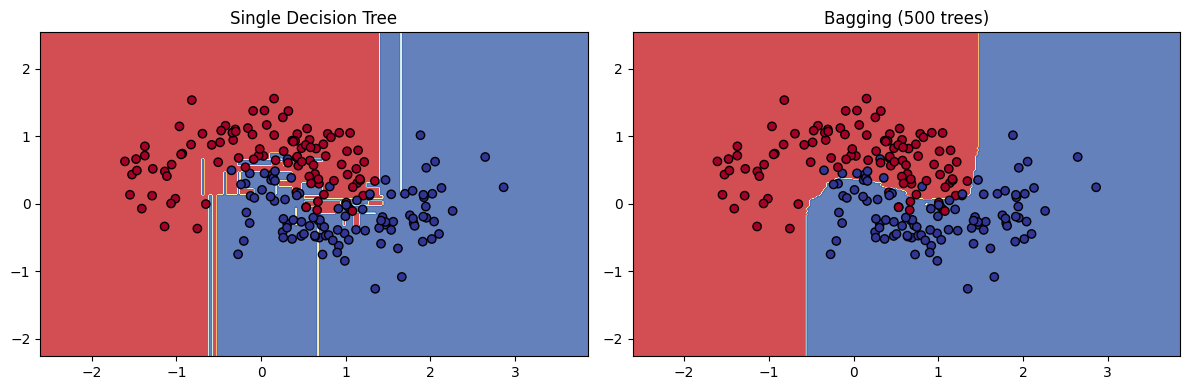

In [16]:
# Buat visualisasi perbandingan
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Single Decision Tree
single_tree = DecisionTreeClassifier(random_state=42)
single_tree.fit(X_train, y_train)

# Plot decision boundary untuk single tree
def plot_decision_boundary(clf, X, y, ax, title):
    # Buat mesh grid
    h = 0.02
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    
    # Prediksi untuk setiap point di mesh
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu, edgecolors='black')
    ax.set_title(title)

plot_decision_boundary(single_tree, X_test, y_test, axes[0], "Single Decision Tree")
plot_decision_boundary(bag_clf, X_test, y_test, axes[1], "Bagging (500 trees)")

plt.tight_layout()
plt.show()

## 3. Out-of-Bag (OOB) Evaluation

### Penjelasan Teoretis

Dalam bagging, sekitar 63% dari training instances digunakan untuk setiap predictor, sisanya 37% tidak digunakan dan disebut **out-of-bag instances**. OOB instances ini dapat digunakan untuk evaluasi tanpa memerlukan validation set terpisah.

**Mengapa 63%?**
Probabilitas sebuah instance tidak terpilih dalam satu draw adalah (1-1/m). Untuk m draws (bootstrap sampling), probabilitas tidak terpilih sama sekali adalah (1-1/m)^m, yang mendekati 1/e ≈ 0.37 atau 37%. Jadi yang terpilih sekitar 63%.


In [17]:
# OOB Evaluation
bag_clf_oob = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), 
    n_estimators=500,
    bootstrap=True, 
    n_jobs=-1, 
    oob_score=True,  # Aktifkan OOB evaluation
    random_state=42
)

bag_clf_oob.fit(X_train, y_train)

# OOB Score
print(f"OOB Score: {bag_clf_oob.oob_score_:.3f}")

# Bandingkan dengan test set accuracy
y_pred = bag_clf_oob.predict(X_test)
print(f"Test Set Accuracy: {accuracy_score(y_test, y_pred):.3f}")

# OOB decision function (probabilities)
print("OOB Decision Function (first 5 samples):")
print(bag_clf_oob.oob_decision_function_[:5])

OOB Score: 0.899
Test Set Accuracy: 0.905
OOB Decision Function (first 5 samples):
[[0.         1.        ]
 [1.         0.        ]
 [1.         0.        ]
 [1.         0.        ]
 [0.07954545 0.92045455]]


## 4. Random Patches dan Random Subspaces

### Penjelasan Teoretis

Selain sampling instances, kita juga bisa melakukan sampling pada features:

- **Random Patches**: Sampling baik instances maupun features
- **Random Subspaces**: Sampling hanya features (menggunakan semua instances)

Teknik ini sangat berguna untuk high-dimensional data seperti images.

In [18]:
# Random Patches: sampling instances dan features
random_patches_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=0.8,      # 80% instances
    max_features=0.8,     # 80% features
    bootstrap=True,
    bootstrap_features=True,
    n_jobs=-1,
    random_state=42
)

# Random Subspaces: semua instances, sampling features
random_subspaces_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42),
    n_estimators=500,
    max_samples=1.0,      # 100% instances
    max_features=0.8,     # 80% features
    bootstrap=False,
    bootstrap_features=True,
    n_jobs=-1,
    random_state=42
)

# Latih dan evaluasi
random_patches_clf.fit(X_train, y_train)
random_subspaces_clf.fit(X_train, y_train)

print(f"Random Patches Accuracy: {accuracy_score(y_test, random_patches_clf.predict(X_test)):.3f}")
print(f"Random Subspaces Accuracy: {accuracy_score(y_test, random_subspaces_clf.predict(X_test)):.3f}")

Random Patches Accuracy: 0.795
Random Subspaces Accuracy: 0.645


## 5. Random Forests

### Penjelasan Teoretis

**Random Forest** adalah ensemble dari Decision Trees yang dilatih menggunakan bagging method. Perbedaan utama dengan bagging biasa adalah Random Forest menambahkan randomness tambahan saat membangun trees: daripada mencari feature terbaik saat splitting node, Random Forest mencari feature terbaik dari subset random features.

### Keunggulan Random Forest

1. **Extra Randomness**: Meningkatkan diversity antar trees
2. **Bias-Variance Tradeoff**: Sedikit meningkat bias untuk menurunkan variance secara signifikan
3. **Feature Importance**: Dapat mengukur kepentingan setiap feature
4. **Robustness**: Tahan terhadap overfitting


In [19]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
rnd_clf = RandomForestClassifier(
    n_estimators=500, 
    max_leaf_nodes=16, 
    n_jobs=-1,
    random_state=42
)

rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.3f}")

# Equivalent Bagging Classifier
bag_clf_equivalent = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, 
    max_samples=1.0, 
    bootstrap=True, 
    n_jobs=-1,
    random_state=42
)

bag_clf_equivalent.fit(X_train, y_train)
y_pred_bag = bag_clf_equivalent.predict(X_test)
print(f"Equivalent Bagging Accuracy: {accuracy_score(y_test, y_pred_bag):.3f}")

Random Forest Accuracy: 0.925
Equivalent Bagging Accuracy: 0.915


### Feature Importance dengan Random Forest

Feature Importances:
sepal length (cm): 0.112
sepal width (cm): 0.023
petal length (cm): 0.441
petal width (cm): 0.423


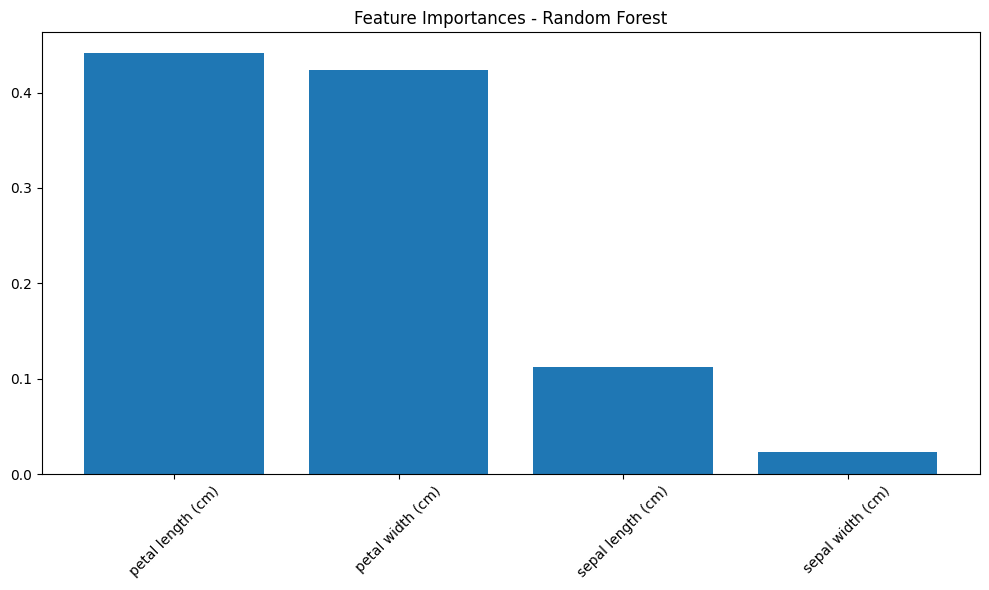

In [20]:
from sklearn.datasets import load_iris

# Load iris dataset untuk demonstrasi feature importance
iris = load_iris()
rnd_clf_iris = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf_iris.fit(iris["data"], iris["target"])

# Display feature importance
print("Feature Importances:")
for name, score in zip(iris["feature_names"], rnd_clf_iris.feature_importances_):
    print(f"{name}: {score:.3f}")

# Visualisasi feature importance
plt.figure(figsize=(10, 6))
feature_names = iris["feature_names"]
importances = rnd_clf_iris.feature_importances_
indices = np.argsort(importances)[::-1]

plt.bar(range(len(importances)), importances[indices])
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=45)
plt.title("Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

## 6. Extra-Trees

### Penjelasan Teoretis

**Extremely Randomized Trees** (Extra-Trees) adalah varian Random Forest yang lebih random. Selain menggunakan random subset of features, Extra-Trees juga menggunakan random thresholds untuk setiap feature, bukan mencari threshold terbaik.

### Keuntungan Extra-Trees

1. **Lebih Cepat**: Tidak perlu mencari threshold optimal
2. **Lebih Random**: Mengurangi variance lebih jauh
3. **Bias-Variance**: Trade-off bias yang lebih tinggi untuk variance yang lebih rendah

In [21]:
from sklearn.ensemble import ExtraTreesClassifier

# Extra-Trees Classifier
extra_clf = ExtraTreesClassifier(
    n_estimators=500,
    max_leaf_nodes=16,
    n_jobs=-1,
    random_state=42
)

extra_clf.fit(X_train, y_train)
y_pred_extra = extra_clf.predict(X_test)
print(f"Extra-Trees Accuracy: {accuracy_score(y_test, y_pred_extra):.3f}")

# Perbandingan waktu training (simulasi dengan dataset kecil)
import time

start_time = time.time()
rnd_clf.fit(X_train, y_train)
rf_time = time.time() - start_time

start_time = time.time()
extra_clf.fit(X_train, y_train)
extra_time = time.time() - start_time

print(f"Random Forest training time: {rf_time:.3f} seconds")
print(f"Extra-Trees training time: {extra_time:.3f} seconds")

Extra-Trees Accuracy: 0.885
Random Forest training time: 0.835 seconds
Extra-Trees training time: 0.557 seconds


## 7. Boosting

### Penjelasan Teoretis

**Boosting** adalah ensemble method yang melatih predictors secara sequential, dimana setiap predictor mencoba memperbaiki kesalahan predecessor-nya. Ada dua jenis boosting utama:

1. **AdaBoost** (Adaptive Boosting)
2. **Gradient Boosting**

### AdaBoost

AdaBoost bekerja dengan:
1. Melatih base classifier pertama
2. Meningkatkan weight dari misclassified instances
3. Melatih classifier kedua dengan updated weights
4. Ulangi proses hingga jumlah estimator yang diinginkan

In [25]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Classifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1, random_state=42),  # Decision Stumps
    n_estimators=200,
    algorithm="SAMME",  # SAMME algorithm for discrete boosting
    learning_rate=0.5,
    random_state=42
)

ada_clf.fit(X_train, y_train)
y_pred_ada = ada_clf.predict(X_test)
print(f"AdaBoost Accuracy: {accuracy_score(y_test, y_pred_ada):.3f}")

c:\Users\pandu\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The parameter 'algorithm' is deprecated in 1.6 and has no effect. It will be removed in version 1.8.
  warnings.warn(


AdaBoost Accuracy: 0.925


### Gradient Boosting

Gradient Boosting bekerja dengan fitting predictor baru pada residual errors dari predictor sebelumnya.

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Classifier
gb_clf = GradientBoostingClassifier(
    max_depth=2,
    n_estimators=200,
    learning_rate=0.1,
    random_state=42
)

gb_clf.fit(X_train, y_train)
y_pred_gb = gb_clf.predict(X_test)
print(f"Gradient Boosting Accuracy: {accuracy_score(y_test, y_pred_gb):.3f}")

Gradient Boosting Accuracy: 0.925


### Gradient Boosting untuk Regression

In [27]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error

# Buat regression dataset
X_reg, y_reg = make_regression(n_samples=1000, n_features=1, noise=10, random_state=42)
X_reg_train, X_reg_test, y_reg_train, y_reg_test = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

# Manual Gradient Boosting (3 trees)
from sklearn.tree import DecisionTreeRegressor

# Tree 1
tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X_reg_train, y_reg_train)

# Tree 2 (fit residuals)
y2 = y_reg_train - tree_reg1.predict(X_reg_train)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=43)
tree_reg2.fit(X_reg_train, y2)

# Tree 3 (fit residuals)
y3 = y2 - tree_reg2.predict(X_reg_train)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=44)
tree_reg3.fit(X_reg_train, y3)

# Ensemble prediction
y_pred_ensemble = (tree_reg1.predict(X_reg_test) + 
                  tree_reg2.predict(X_reg_test) + 
                  tree_reg3.predict(X_reg_test))

# Scikit-Learn Gradient Boosting
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X_reg_train, y_reg_train)
y_pred_gbrt = gbrt.predict(X_reg_test)

print(f"Manual GBRT MSE: {mean_squared_error(y_reg_test, y_pred_ensemble):.3f}")
print(f"Scikit-Learn GBRT MSE: {mean_squared_error(y_reg_test, y_pred_gbrt):.3f}")

Manual GBRT MSE: 131.186
Scikit-Learn GBRT MSE: 131.186


### Early Stopping untuk Gradient Boosting

Optimal number of estimators: 40
Best validation error: 116.861


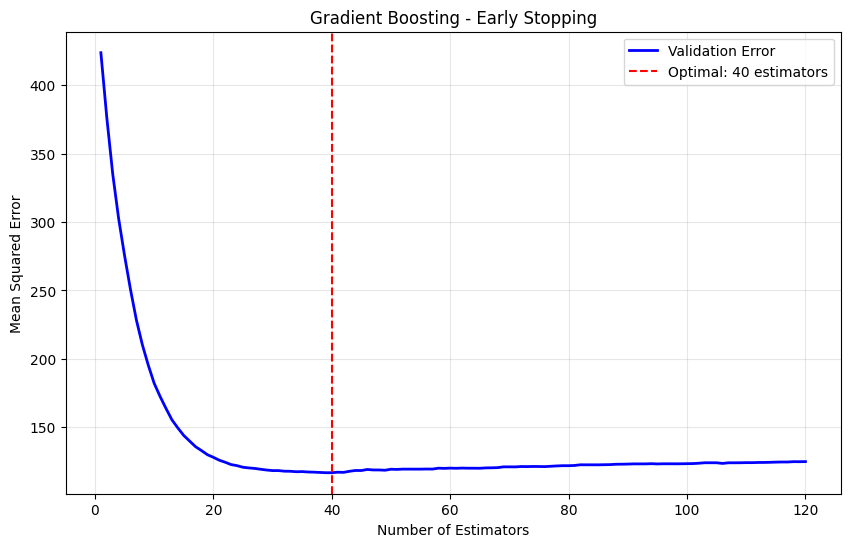

In [28]:
from sklearn.model_selection import train_test_split

# Split data untuk validation
X_reg_train, X_reg_val, y_reg_train, y_reg_val = train_test_split(X_reg_train, y_reg_train, test_size=0.2, random_state=42)

# Train dengan banyak estimators
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_reg_train, y_reg_train)

# Hitung validation errors untuk setiap stage
errors = [mean_squared_error(y_reg_val, y_pred) 
          for y_pred in gbrt.staged_predict(X_reg_val)]

# Temukan optimal number of trees
bst_n_estimators = np.argmin(errors) + 1

# Train model dengan optimal number of estimators
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_reg_train, y_reg_train)

print(f"Optimal number of estimators: {bst_n_estimators}")
print(f"Best validation error: {min(errors):.3f}")

# Plot validation errors
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(errors) + 1), errors, 'b-', linewidth=2, label='Validation Error')
plt.axvline(bst_n_estimators, color='r', linestyle='--', label=f'Optimal: {bst_n_estimators} estimators')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Squared Error')
plt.title('Gradient Boosting - Early Stopping')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 8. Stacking

### Penjelasan Teoretis

**Stacking** (Stacked Generalization) adalah teknik ensemble yang menggunakan meta-learner (blender) untuk mempelajari cara terbaik menggabungkan prediksi dari base learners.

### Proses Stacking

1. Split training set menjadi dua subset
2. Latih base learners pada subset pertama
3. Gunakan base learners untuk predict pada subset kedua
4. Latih blender menggunakan prediksi sebagai features dan target asli sebagai target

In [29]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression

# Base learners
log_clf = LogisticRegression(random_state=42)
svm_clf = SVC(probability=True, random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)

# Generate cross-validated predictions untuk training blender
def get_stacking_predictions(estimators, X, y):
    predictions = np.zeros((X.shape[0], len(estimators)))
    
    for i, estimator in enumerate(estimators):
        # Gunakan cross_val_predict untuk menghindari overfitting
        pred_prob = cross_val_predict(estimator, X, y, cv=3, method='predict_proba')
        predictions[:, i] = pred_prob[:, 1]  # Ambil probability untuk class 1
    
    return predictions

# Base learners
base_learners = [log_clf, svm_clf, rnd_clf]

# Generate predictions untuk stacking
stacking_train_preds = get_stacking_predictions(base_learners, X_train, y_train)

# Train blender
blender = LogisticRegression(random_state=42)
blender.fit(stacking_train_preds, y_train)

# Untuk prediction, latih base learners pada full training set
for estimator in base_learners:
    estimator.fit(X_train, y_train)

# Generate predictions untuk test set
test_preds = np.zeros((X_test.shape[0], len(base_learners)))
for i, estimator in enumerate(base_learners):
    test_preds[:, i] = estimator.predict_proba(X_test)[:, 1]

# Final prediction menggunakan blender
stacking_pred = blender.predict(test_preds)
stacking_accuracy = accuracy_score(y_test, stacking_pred)

print(f"Stacking Ensemble Accuracy: {stacking_accuracy:.3f}")

# Bandingkan dengan individual classifiers
print("\nPerbandingan dengan Individual Classifiers:")
for i, estimator in enumerate(base_learners):
    individual_pred = estimator.predict(X_test)
    individual_accuracy = accuracy_score(y_test, individual_pred)
    print(f"{estimator.__class__.__name__}: {individual_accuracy:.3f}")

Stacking Ensemble Accuracy: 0.930

Perbandingan dengan Individual Classifiers:
LogisticRegression: 0.820
SVC: 0.915
RandomForestClassifier: 0.905


## 9. Perbandingan Semua Metode Ensemble

Perbandingan Semua Ensemble Methods:
Logistic Regression : 0.820
Random Forest       : 0.905
SVM                 : 0.915
Hard Voting         : 0.905
Soft Voting         : 0.920
Bagging             : 0.895
Extra Trees         : 0.915
AdaBoost            : 0.920
Gradient Boosting   : 0.905


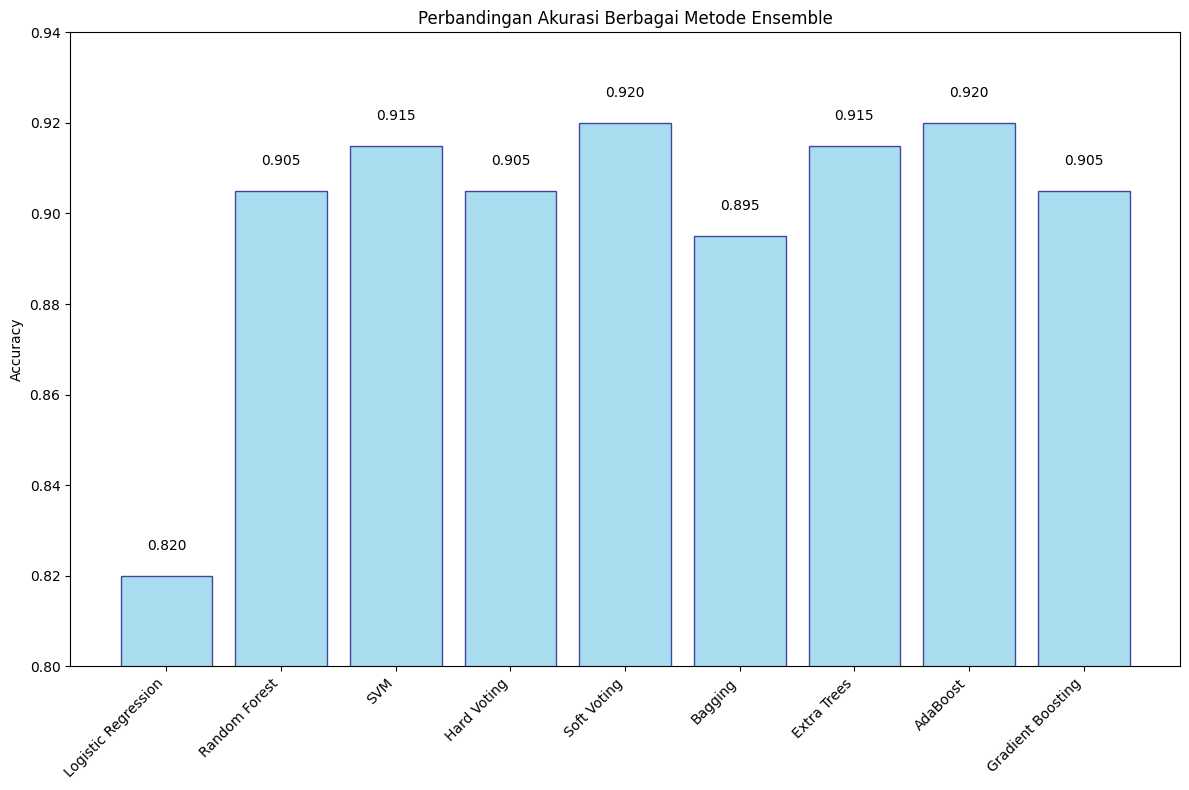


Metode Terbaik: Soft Voting dengan akurasi 0.920


In [30]:
# Dictionary untuk menyimpan semua hasil
ensemble_results = {}

# List semua ensemble methods yang akan dibandingkan
ensemble_methods = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'SVM': SVC(random_state=42),
    'Hard Voting': VotingClassifier([
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svm', SVC(random_state=42))
    ], voting='hard'),
    'Soft Voting': VotingClassifier([
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svm', SVC(probability=True, random_state=42))
    ], voting='soft'),
    'Bagging': BaggingClassifier(DecisionTreeClassifier(random_state=42), 
                                n_estimators=100, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1, random_state=42),
                                  n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42)
}

# Evaluasi semua methods
print("Perbandingan Semua Ensemble Methods:")
print("=" * 50)

for name, clf in ensemble_methods.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    ensemble_results[name] = accuracy
    print(f"{name:<20}: {accuracy:.3f}")

# Visualisasi hasil
plt.figure(figsize=(12, 8))
methods = list(ensemble_results.keys())
accuracies = list(ensemble_results.values())

bars = plt.bar(methods, accuracies, color='skyblue', edgecolor='navy', alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Perbandingan Akurasi Berbagai Metode Ensemble')
plt.xticks(rotation=45, ha='right')
plt.ylim(0.8, max(accuracies) + 0.02)

# Tambahkan nilai akurasi di atas setiap bar
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
             f'{acc:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Tampilkan metode terbaik
best_method = max(ensemble_results, key=ensemble_results.get)
print(f"\nMetode Terbaik: {best_method} dengan akurasi {ensemble_results[best_method]:.3f}")

## 10. Kesimpulan dan Best Practices

### Kapan Menggunakan Metode Ensemble Tertentu?

1. **Voting Classifiers**:
   - Gunakan ketika Anda memiliki beberapa model dengan performa yang baik
   - Soft voting umumnya lebih baik jika semua classifier dapat mengeluarkan probabilitas

2. **Bagging/Random Forest**:
   - Sangat baik untuk mengurangi overfitting
   - Cocok untuk model dengan high variance (seperti Decision Trees)
   - Random Forest adalah pilihan default yang sangat baik

3. **Boosting**:
   - AdaBoost: Baik untuk binary classification dengan weak learners
   - Gradient Boosting: Sangat powerful, tetapi lebih rentan overfitting
   - Perlu tuning yang hati-hati untuk learning rate dan number of estimators

4. **Stacking**:
   - Paling complex tapi berpotensi memberikan hasil terbaik
   - Memerlukan validation yang hati-hati untuk menghindari overfitting

### Tips Praktis

In [31]:
# Tips untuk implementasi ensemble yang baik
print("Best Practices untuk Ensemble Learning:")
print("=" * 50)
print("1. Diversity is Key: Gunakan algoritma yang berbeda-beda")
print("2. Cross-validation: Selalu gunakan CV untuk evaluasi yang fair")
print("3. Feature Engineering: Ensemble bukan pengganti feature engineering yang baik")
print("4. Computational Cost: Pertimbangkan trade-off antara akurasi dan waktu komputasi")
print("5. Interpretability: Ensemble sulit diinterpretasi, pertimbangkan kebutuhan bisnis")
print("6. Overfitting: Monitor validation performance, terutama untuk boosting")
print("7. Data Quality: Ensemble tidak akan memperbaiki data yang buruk")

Best Practices untuk Ensemble Learning:
1. Diversity is Key: Gunakan algoritma yang berbeda-beda
2. Cross-validation: Selalu gunakan CV untuk evaluasi yang fair
3. Feature Engineering: Ensemble bukan pengganti feature engineering yang baik
4. Computational Cost: Pertimbangkan trade-off antara akurasi dan waktu komputasi
5. Interpretability: Ensemble sulit diinterpretasi, pertimbangkan kebutuhan bisnis
6. Overfitting: Monitor validation performance, terutama untuk boosting
7. Data Quality: Ensemble tidak akan memperbaiki data yang buruk


### Ringkasan Konsep Kunci

In [32]:
# Tabel ringkasan karakteristik setiap metode
import pandas as pd

ensemble_summary = pd.DataFrame({
    'Method': ['Voting', 'Bagging', 'Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boosting', 'Stacking'],
    'Training': ['Parallel', 'Parallel', 'Parallel', 'Parallel', 'Sequential', 'Sequential', 'Multi-stage'],
    'Bias': ['Low', 'Similar', 'Similar', 'Higher', 'Lower', 'Lower', 'Lower'],
    'Variance': ['Lower', 'Lower', 'Lower', 'Lower', 'Similar', 'Lower', 'Lower'],
    'Overfitting Risk': ['Low', 'Low', 'Low', 'Low', 'Medium', 'High', 'Medium'],
    'Interpretability': ['Medium', 'Low', 'Low', 'Low', 'Low', 'Low', 'Very Low']
})

print("Ringkasan Karakteristik Metode Ensemble:")
print(ensemble_summary.to_string(index=False))

Ringkasan Karakteristik Metode Ensemble:
           Method    Training    Bias Variance Overfitting Risk Interpretability
           Voting    Parallel     Low    Lower              Low           Medium
          Bagging    Parallel Similar    Lower              Low              Low
    Random Forest    Parallel Similar    Lower              Low              Low
      Extra Trees    Parallel  Higher    Lower              Low              Low
         AdaBoost  Sequential   Lower  Similar           Medium              Low
Gradient Boosting  Sequential   Lower    Lower             High              Low
         Stacking Multi-stage   Lower    Lower           Medium         Very Low


## Latihan dan Eksperimen Lanjutan

In [33]:
# Eksperimen dengan hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Grid search untuk Random Forest
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf_grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid_search.fit(X_train, y_train)
print("Best Random Forest Parameters:")
print(rf_grid_search.best_params_)
print(f"Best CV Score: {rf_grid_search.best_score_:.3f}")

# Grid search untuk Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

gb_grid_search = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

gb_grid_search.fit(X_train, y_train)
print("\nBest Gradient Boosting Parameters:")
print(gb_grid_search.best_params_)
print(f"Best CV Score: {gb_grid_search.best_score_:.3f}")

Best Random Forest Parameters:
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}
Best CV Score: 0.914

Best Gradient Boosting Parameters:
{'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 50}
Best CV Score: 0.908


Notebook ini memberikan pemahaman komprehensif tentang Ensemble Learning, mulai dari konsep dasar hingga implementasi praktis. Setiap metode dijelaskan dengan detail teoretis dan implementasi kode yang dapat langsung dijalankan.